In [1]:
import logging
import time
from datetime import timedelta
from io import BytesIO
from multiprocessing import Pool, cpu_count
from pathlib import Path

import boto3
import contextily as ctx
import datashader as ds
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rio
import s2sphere
import xarray as xr
from botocore.config import Config
from owslib.wfs import WebFeatureService
from rasterstats import zonal_stats
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.stats import genextreme
from shapely.ops import unary_union

In [146]:
# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

project_root = Path.cwd().parent

In [147]:
# Color constants for consistent visualization
COLORS = {
    "water": "#2E86C1",  # Blue for water courses
    "buildings": "#E67E22",  # Orange for buildings
    "flood": "#3498DB",  # Light blue for flood areas
    "population": "#E74C3C",  # Red for population density
    "exceedance": "#2E86C1",  # Blue for exceedance curve
    "exceedance_fit": "#E74C3C",  # Red for fitted curve
    "boundary": "#2C3E50",  # Dark blue-gray for boundaries
}

In [148]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Get the data
    response = wfs.getfeature(typename=layer_name, srsname=srs)

    # Read the response into a GeoDataFrame
    return gpd.read_file(BytesIO(response.read()))

In [70]:
# Load Nono boundary data and project to Web Mercator once
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

# Load water courses data and project directly to Web Mercator
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.overlay(cursos_agua_3857, nono_3857, how='intersection')

cuerpos_de_agua = load_wfs_layer("idecor:embalses")
cuerpos_de_agua_3857 = cuerpos_de_agua.to_crs(epsg=3857)
cuerpos_de_agua_nono_3857 = gpd.overlay(cuerpos_de_agua_3857, nono_3857, how='intersection')

In [120]:
def scale_line_width(orden):
    return 3 - (orden - 2) * (2.5 / 3)

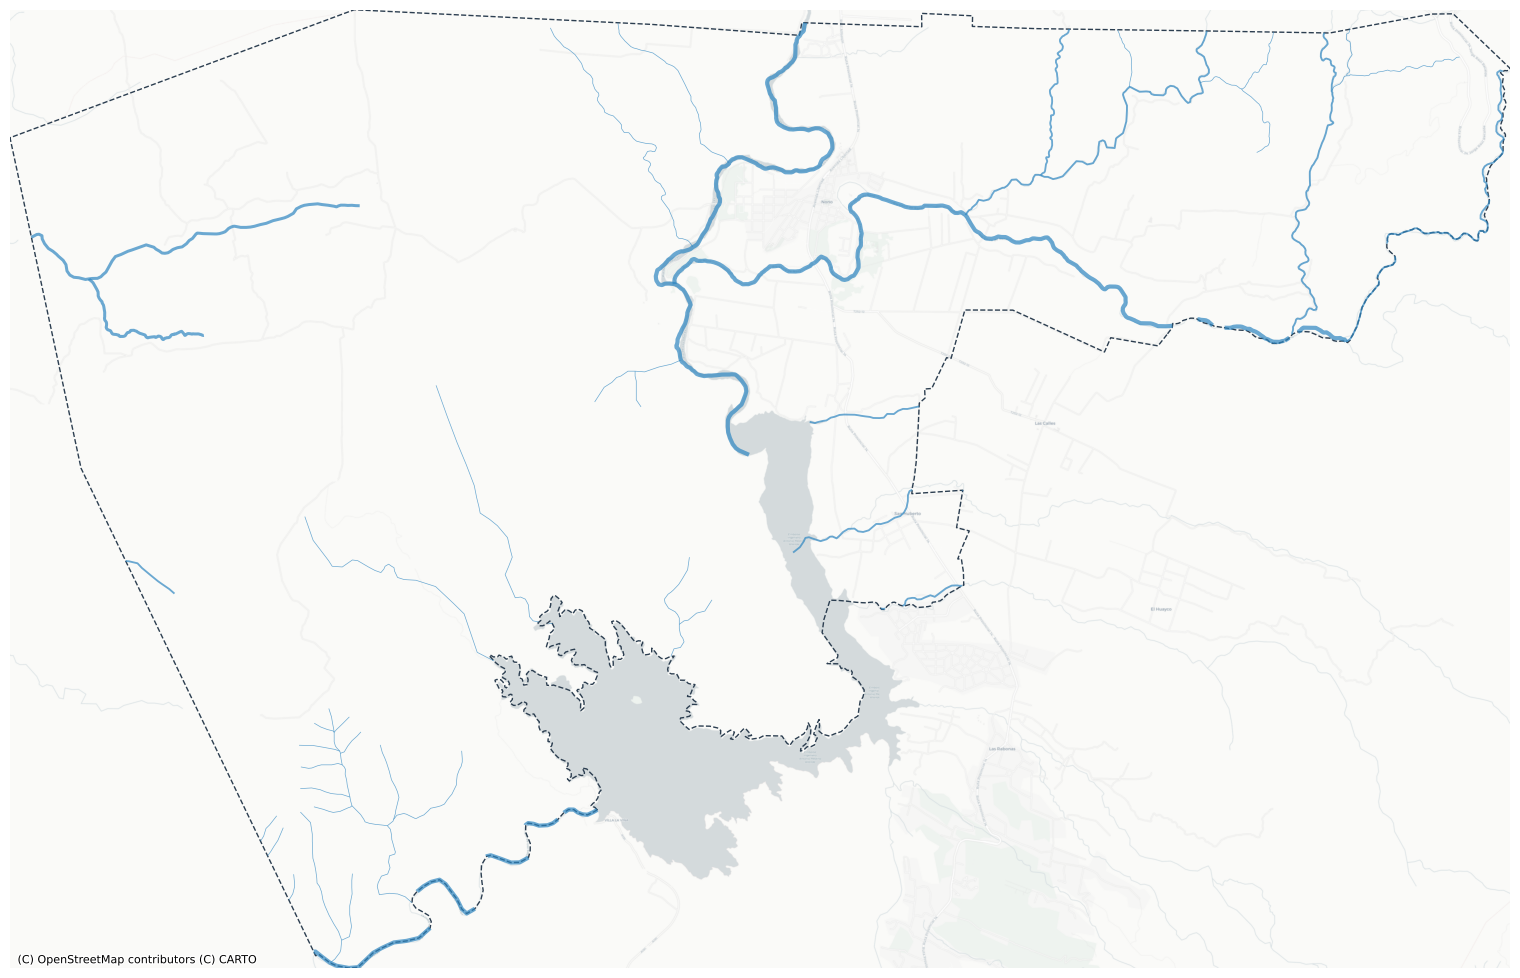

In [149]:

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=nono_3857.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Remove axis labels and ticks
ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

In [4]:
# Load flood depth data
flood_depth_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"
flood_depth = load_raster_data(flood_depth_url)

# Reproject to Web Mercator and clip to Nono extent
flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

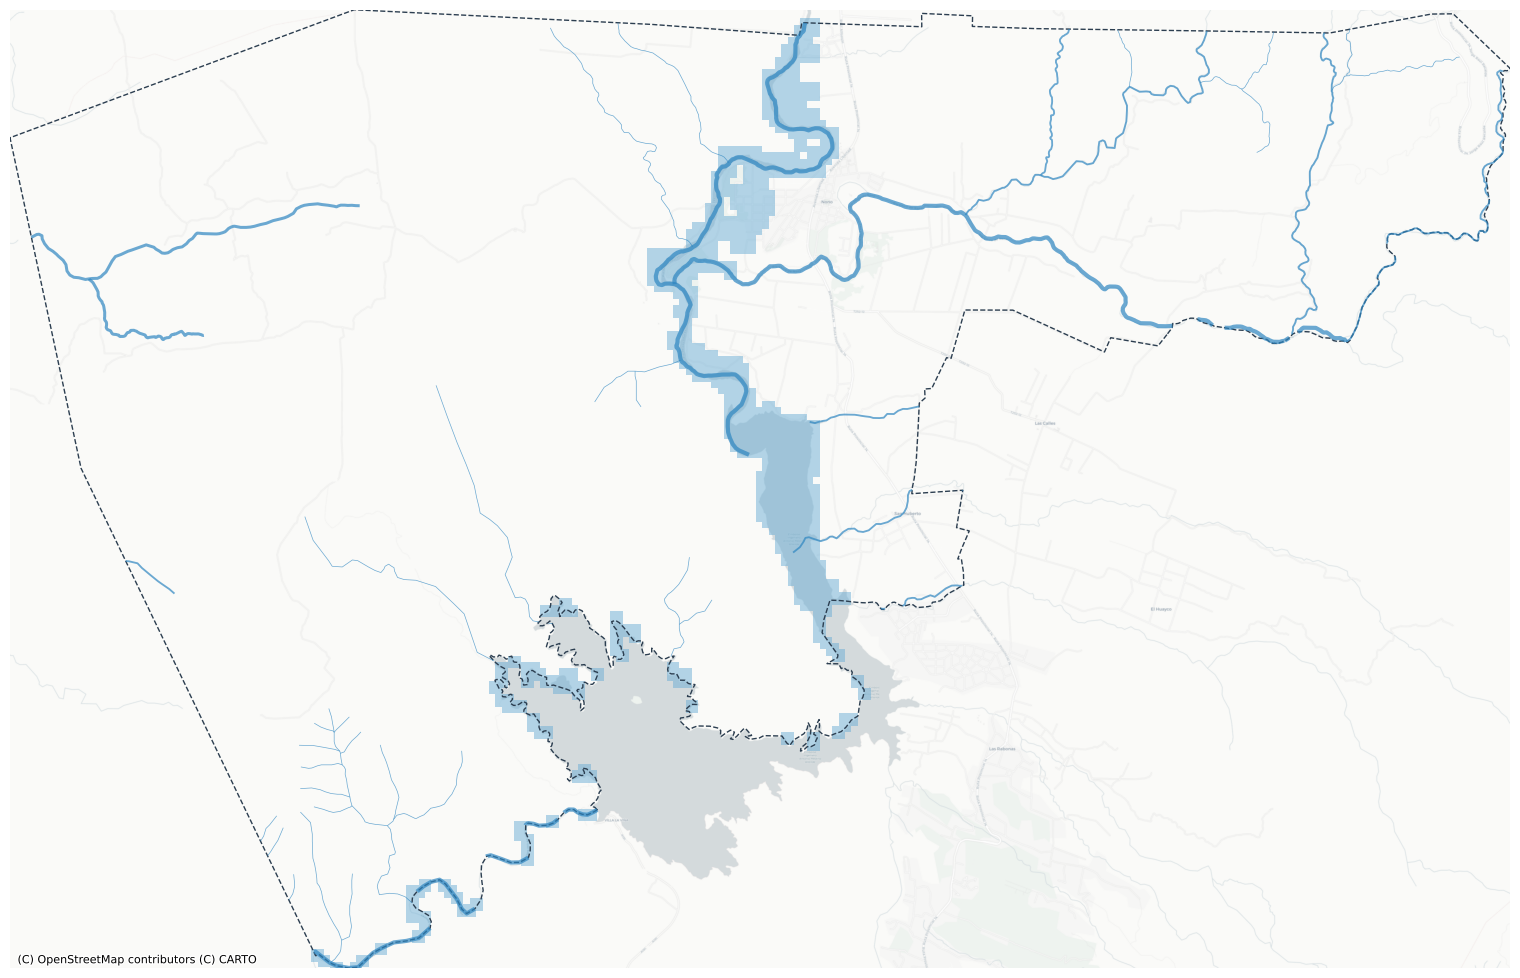

In [151]:

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=flood_depth_3857.rio.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,
)

# Plot the flood mask - only show where it's True
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax, alpha=0.5, cmap="Blues", zorder=1, add_colorbar=False
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Remove axis labels and ticks
ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()


In [5]:
# Load GHSL data
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

# Reproject and clip GHSL data in one step
ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry)


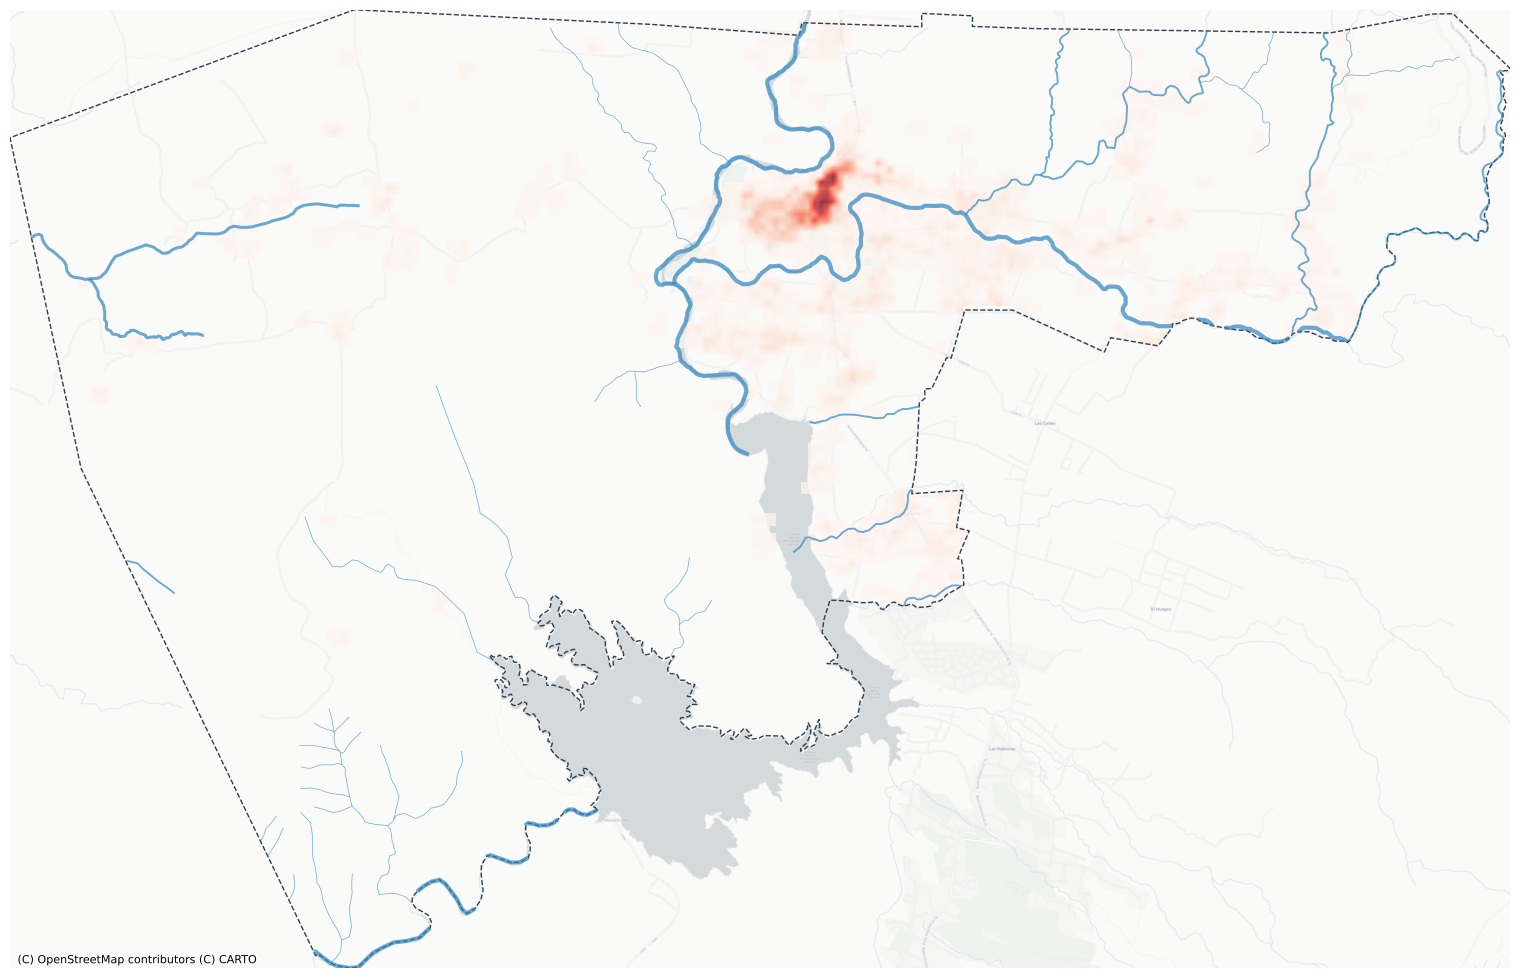

In [153]:

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Rasterize the GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=ghsl_3857.rio.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,
)

# Plot the GHSL data with plasma colormap, excluding zeros
ghsl_agg.where(ghsl_agg > 0).plot.imshow(
    ax=ax, cmap="Reds", zorder=1, add_colorbar=False, alpha=0.75
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Remove axis labels and ticks
ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

In [6]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())

    if parent_id in partitions:
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")  # or whatever region is appropriate
con.execute("SET s3_endpoint='data.source.coop'")  # Note: removed https://
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

Level 10: 10677235371542052864
Level 9: 10677238670076936192
Level 8: 10677243068123447296
Level 7: 10677260660309491712
Level 6: 10677190291565314048
Level 5: 10676908816588603392
Level 4: 10678034716495446016
Level 3: 10682538316122816512
Found match at level 3!


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

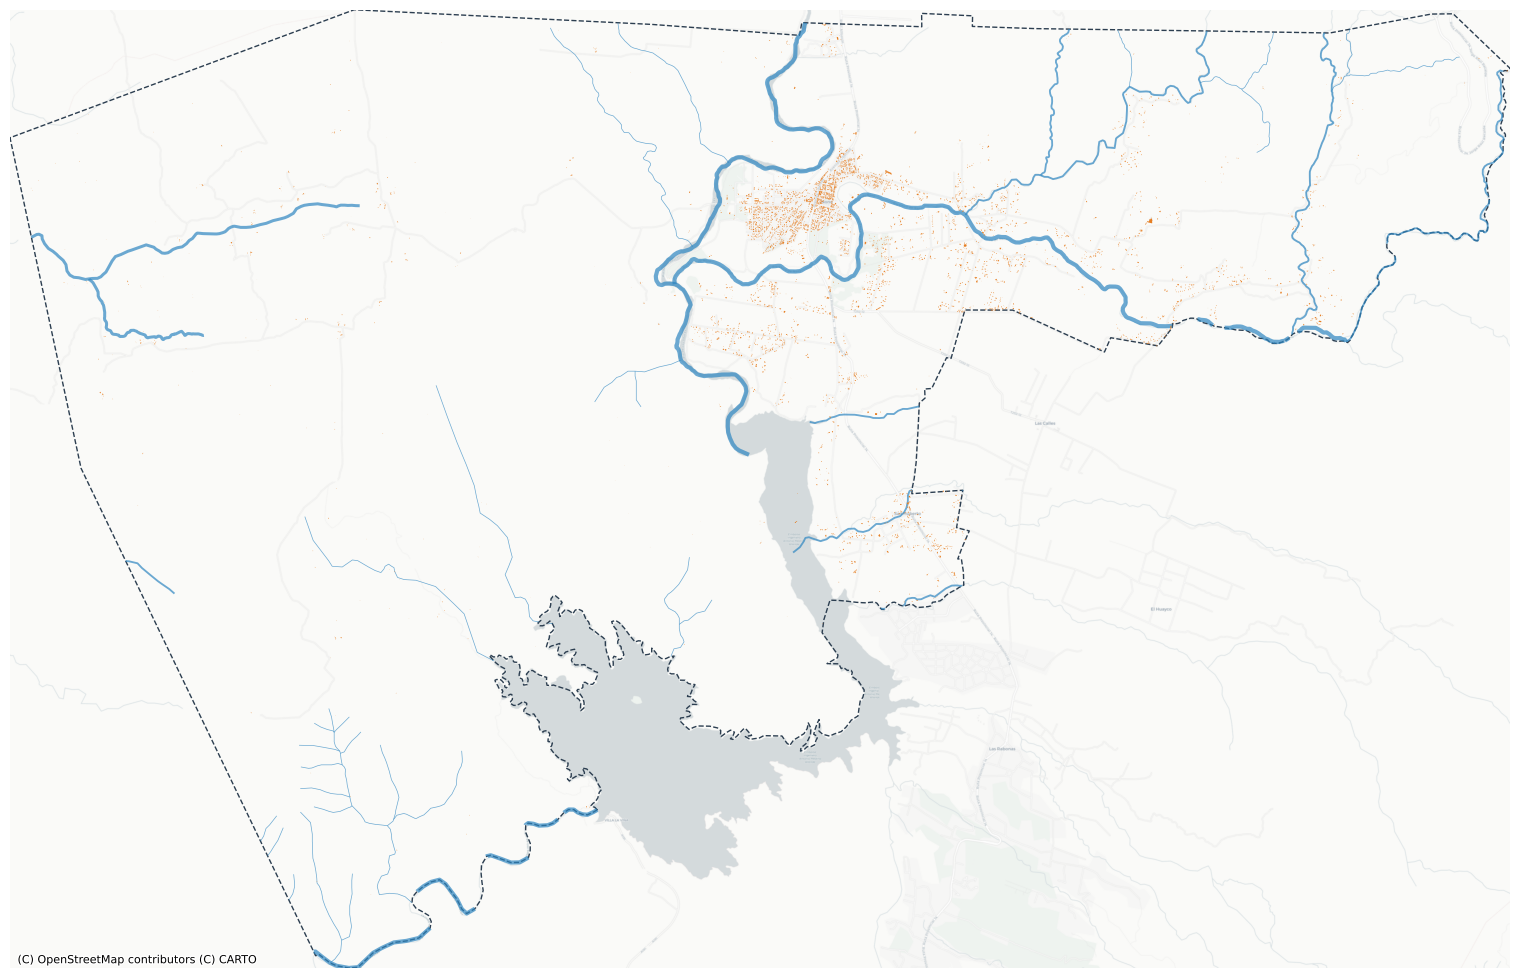

In [154]:

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=nono_3857.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot buildings in dark orange/brown without edges
buildings_3857.plot(
    ax=ax,
    color=COLORS["buildings"],
    zorder=4,
)

# Remove axis labels and ticks
ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

In [156]:

def union(x):
    return unary_union(x)


# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Get coordinates and values
x, y = flood_depth_3857.x.values, flood_depth_3857.y.values
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
values = flood_mask.sel(band=1).values.flatten()

# Convert to DataFrame and filter for flood areas
flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
flood_pd = flood_pd[flood_pd["flood"] == True]

# Create vector data
flood_vector = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_xy(
        flood_pd["x"], flood_pd["y"], crs=flood_depth_3857.rio.crs
    )
)
flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons

# Convert to list of geometries and chunk for parallel processing
geoms = list(flood_vector.geometry)
geom_arr = [geoms[i : i + 10000] for i in range(0, len(geoms), 10000)]

# Parallel union operation
with Pool(cpu_count()) as p:
    geom_union = p.map(union, geom_arr)

# Final union
flood_polygons = unary_union(geom_union)
flood_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries(flood_polygons), crs=flood_depth_3857.rio.crs
)

# Calculate population statistics
affine = ghsl_3857.rio.transform()
stats = zonal_stats(
    flood_gdf.geometry.tolist(),
    ghsl_3857.sel(band=1).values,
    stats=["sum"],
    nodata=-9999,
    affine=affine,
)
population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
total_population = ghsl_3857.sel(band=1).sum().item()
population_percentage = (population_in_flood / total_population) * 100

# Calculate building statistics
buildings_in_flood = gpd.sjoin(
    buildings_3857, flood_gdf, how="inner", predicate="within"
)
total_buildings = len(buildings_3857)
buildings_exposed = len(buildings_in_flood)
buildings_percentage = (buildings_exposed / total_buildings) * 100

# Print results
print("=== Population Analysis ===")
print(f"Total population exposed to flooding: {population_in_flood:,.0f} people")
print(f"Total population in Nono: {total_population:,.0f} people")
print(f"Percentage of population exposed: {population_percentage:.1f}%")
print("\n=== Building Analysis ===")
print(f"Total buildings exposed to flooding: {buildings_exposed:,} buildings")
print(f"Total buildings in Nono: {total_buildings:,} buildings")
print(f"Percentage of buildings exposed: {buildings_percentage:.1f}%")


=== Population Analysis ===
Total population exposed to flooding: 190 people
Total population in Nono: 4,011 people
Percentage of population exposed: 4.7%

=== Building Analysis ===
Total buildings exposed to flooding: 213 buildings
Total buildings in Nono: 5,866 buildings
Percentage of buildings exposed: 3.6%


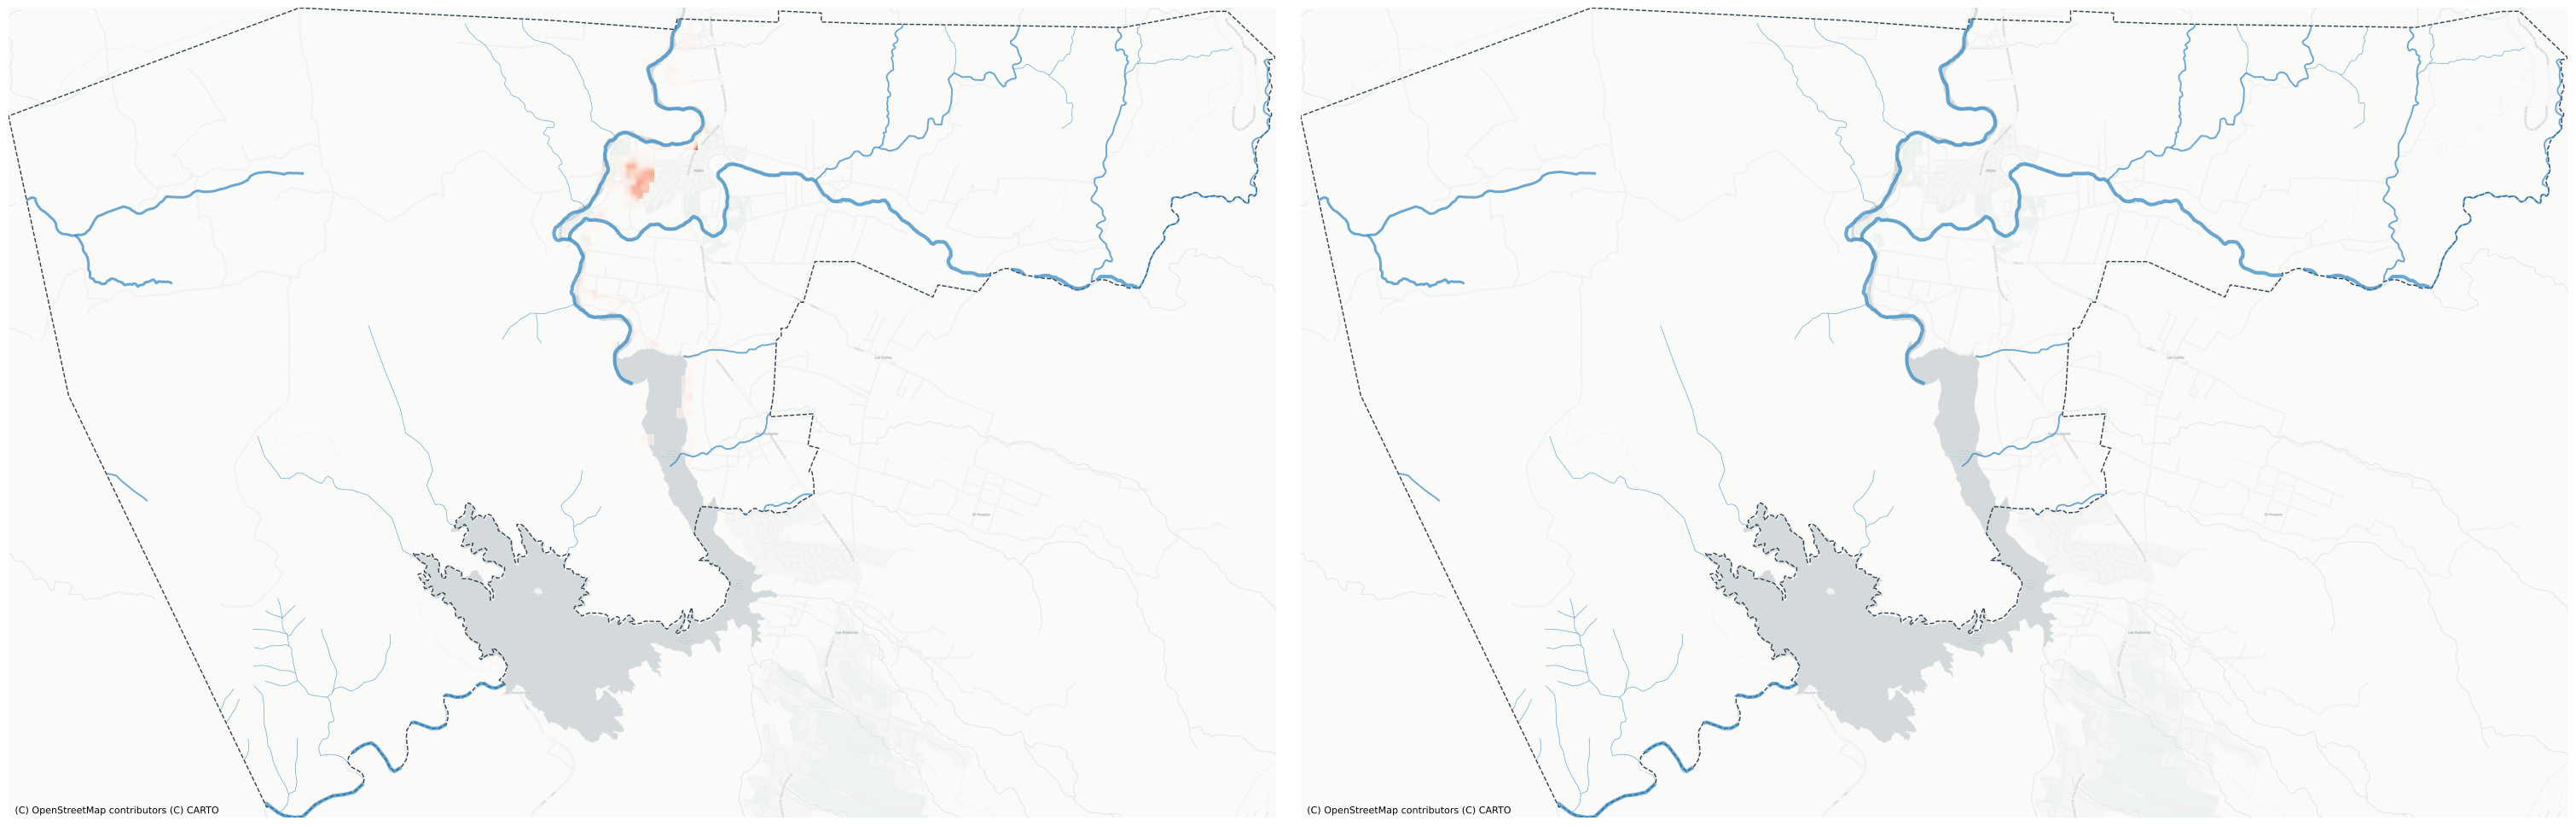

In [155]:
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
for ax in [ax1, ax2]:
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# First rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Then rasterize GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Apply the mask to the rasterized data and remove zero population areas
masked_ghsl = ghsl_agg.where(flood_agg)
masked_ghsl = masked_ghsl.where(masked_ghsl > 0)  # Only show areas with population

# Add basemap to both axes
for ax in [ax1, ax2]:
    ctx.add_basemap(
        ax,
        crs=flood_depth_3857.rio.crs,
        source=ctx.providers.CartoDB.Positron,
        zorder=0,
        zoom=15,
    )

# Plot the masked population data on first axis
masked_ghsl.plot.imshow(ax=ax1, alpha=0.6, cmap="Reds", zorder=1, add_colorbar=False)

# Plot vector data on both axes
for ax in [ax1, ax2]:
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor=COLORS["boundary"],
        linestyle="--",
        linewidth=1,
        zorder=2,
    )

    # Plot water courses
    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3
        )

# Plot only exposed buildings on second axis
buildings_in_flood = gpd.sjoin(
    buildings_3857, flood_gdf, how="inner", predicate="within"
)
total_buildings = len(buildings_3857)
buildings_exposed = len(buildings_in_flood)
buildings_percentage = (buildings_exposed / total_buildings) * 100

# Remove axis labels and ticks
for ax in [ax1, ax2]:
    ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)

plt.show()

In [33]:
import logging
import time
from datetime import timedelta
import xarray as xr

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_all_return_periods(base_url, return_periods):
    """
    Load multiple return period flood depth rasters into a single xarray dataset.
    
    Parameters:
    -----------
    base_url : str
        Base URL for the flood depth data
    return_periods : list
        List of return periods to load (e.g., [10, 20, 50, 75, 100, 200, 500])
    
    Returns:
    --------
    xarray.Dataset
        Dataset containing all return period flood depths
    """
    start_time = time.time()
    logging.info(f"Starting to load {len(return_periods)} return periods")
    
    # Create empty list to store datasets
    datasets = []
    
    # Load each return period
    for i, rp in enumerate(return_periods, 1):
        rp_start = time.time()
        logging.info(f"Loading return period {rp} ({i}/{len(return_periods)})")
        
        # Construct URL for this return period
        url = base_url.replace('RP100', f'RP{rp}')
        logging.info(f"  URL: {url}")
        
        # Load and reproject data
        flood_depth = rio.open_rasterio(url, masked=True)
        
        flood_depth_3857 = flood_depth.rio.reproject(
            dst_crs="EPSG:3857",
            resolution=100,  # 100m resolution
        )
        
        flood_depth_3857 = flood_depth_3857.rio.clip(nono_3857.geometry, from_disk=True)
        
        # Add return period as a dimension
        flood_depth_3857 = flood_depth_3857.expand_dims({'return_period': [rp]})
        
        datasets.append(flood_depth_3857)
    
    
    logging.info("Combining all datasets...")
    combined = xr.concat(datasets, dim='return_period')
    
    total_time = time.time() - start_time
    logging.info(f"Finished loading all return periods in {timedelta(seconds=int(total_time))}")
    
    return combined

# Define return periods and base URL
return_periods = [10, 20, 50, 75, 100, 200, 500]
base_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"

# Load all return periods
flood_depths = load_all_return_periods(base_url, return_periods)

2025-05-22 10:47:36,343 - INFO - Starting to load 7 return periods
2025-05-22 10:47:36,344 - INFO - Loading return period 10 (1/7)
2025-05-22 10:47:36,344 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP10/ID74_S30_W70_RP10_depth.tif
2025-05-22 10:47:36,344 - INFO -   Downloading and opening raster...
2025-05-22 10:47:38,478 - INFO -   Reprojecting to Web Mercator...
2025-05-22 10:47:59,537 - INFO -   Clipping to Nono extent...
2025-05-22 10:48:00,568 - INFO - Completed return period 10 in 0:00:24
2025-05-22 10:48:00,568 - INFO - Loading return period 20 (2/7)
2025-05-22 10:48:00,568 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP20/ID74_S30_W70_RP20_depth.tif
2025-05-22 10:48:00,568 - INFO -   Downloading and opening raster...
2025-05-22 10:48:01,525 - INFO -   Reprojecting to Web Mercator...
2025-05-22 10:48:18,762 - INFO -   Clipping to Nono extent...
2025-05-22 10:48:19,788 - INFO - Completed r

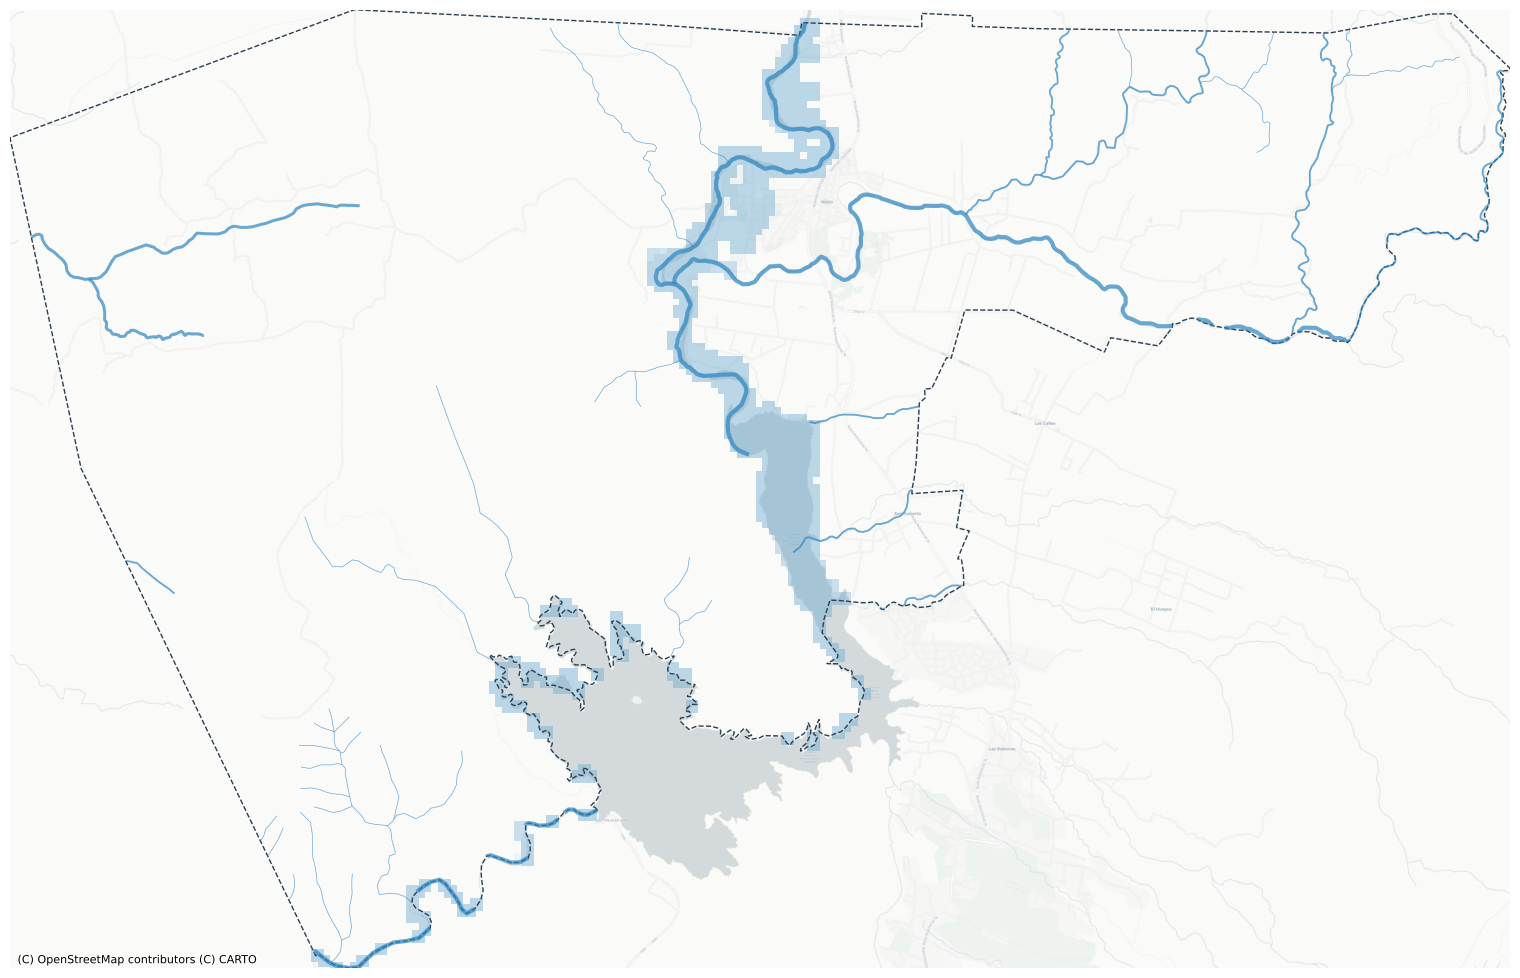

In [157]:

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Add basemap
ctx.add_basemap(
    ax,
    crs=flood_depths.rio.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,
)

# Plot each return period
for rp in flood_depths.return_period.values:
    # Create mask for flood areas for this return period
    flood_mask = flood_depths.sel(return_period=rp) > 0

    # Rasterize the flood mask
    flood_agg = canvas.raster(flood_mask.sel(band=1))

    # Plot the flood mask
    flood_agg.where(flood_agg > 0).plot.imshow(
        ax=ax, alpha=0.075, cmap="Blues", zorder=1, add_colorbar=False
    )

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Remove axis labels and ticks
ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.show()

In [162]:
# Calculate exposure for each return period
exposure_results = []

for rp in flood_depths.return_period.values:
    # Create mask for this return period
    flood_mask = flood_depths.sel(return_period=rp) > 0
    
    # Create flood polygons for this return period
    x, y = flood_depths.x.values, flood_depths.y.values
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()
    values = flood_mask.sel(band=1).values.flatten()
    
    # Convert to DataFrame and filter for flood areas
    # Convert to DataFrame and filter for flood areas
    flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
    flood_pd = flood_pd[
        flood_pd["flood"].astype(bool)
    ]  # Convert to boolean before filtering
    
    # Create vector data
    flood_vector = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_xy(flood_pd['x'], flood_pd['y'], crs=flood_depths.rio.crs)
    )
    flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons
    
    # Convert to list of geometries and chunk for parallel processing
    geoms = list(flood_vector.geometry)
    geom_arr = [geoms[i:i+10000] for i in range(0, len(geoms), 10000)]
    
    # Parallel union operation
    with Pool(cpu_count()) as p:
        geom_union = p.map(union, geom_arr)
    
    # Final union
    flood_polygons = unary_union(geom_union)
    flood_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(flood_polygons), crs=flood_depths.rio.crs)
    
    # Calculate population statistics using intersection
    stats = zonal_stats(
        flood_gdf.geometry.tolist(),
        ghsl_3857.sel(band=1).values,
        stats=['sum', 'count'],
        nodata=-9999,
        affine=affine,
        all_touched=True  # Include cells that touch the boundary
    )
    
    
    population_in_flood = sum(stat['sum'] for stat in stats if stat['sum'] is not None)
    total_population = ghsl_3857.sel(band=1).sum().item()
    population_percentage = (population_in_flood / total_population) * 100
    
    # Calculate building statistics using intersection
    buildings_in_flood = gpd.sjoin(buildings_3857, flood_gdf, how='inner', predicate='intersects')
    total_buildings = len(buildings_3857)
    buildings_exposed = len(buildings_in_flood)
    buildings_percentage = (buildings_exposed / total_buildings) * 100
    
    
    exposure_results.append({
        'return_period': rp,
        'population_exposed': population_in_flood,
        'population_percentage': population_percentage,
        'buildings_exposed': buildings_exposed,
        'buildings_percentage': buildings_percentage
    })

# Convert to DataFrame for easy analysis
exposure_df = pd.DataFrame(exposure_results)

In [163]:
exposure_df

,return_period,population_exposed,population_percentage,buildings_exposed,buildings_percentage
0,10,289.436289,7.216171,254,4.330038
1,20,292.615605,7.295437,254,4.330038
2,50,292.615605,7.295437,254,4.330038
3,75,292.615605,7.295437,254,4.330038
4,100,292.615605,7.295437,254,4.330038
5,200,292.615605,7.295437,254,4.330038
6,500,311.333420,7.762106,268,4.568701


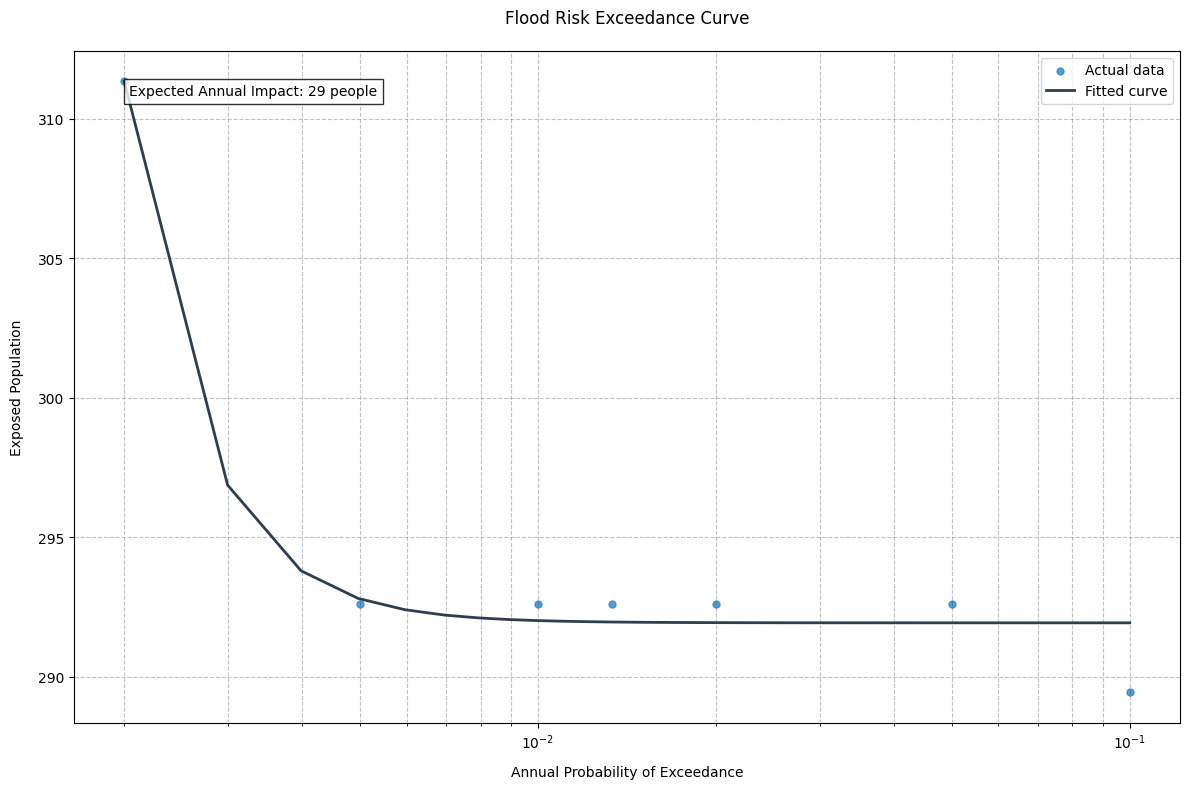

Expected Annual Impact: 29 people
GEV parameters: location = 291.92, scale = 0.00, shape = -3.40


In [170]:
# Convert return periods to annual probabilities
exposure_df['annual_probability'] = 1 / exposure_df['return_period']

# Sort by probability (ascending)
exposure_df = exposure_df.sort_values('annual_probability')

# Create the exceedance curve plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the actual data points
ax.scatter(
    exposure_df['annual_probability'], 
    exposure_df['population_exposed'], 
    color='#2E86C1',  # Nice blue
    label='Actual data',
    s=25,  # More reasonable dot size
    alpha=0.8
)

# Define the GEV function
def gev_function(x, loc, scale, shape):
    return genextreme.ppf(1 - x, shape, loc=loc, scale=scale)

# Fit a curve to the data
x = exposure_df['annual_probability']
y = exposure_df['population_exposed']

# Fit the curve with initial guess
p0 = [100, 50, 0.1]  # Initial guess for parameters (loc, scale, shape)
popt, _ = curve_fit(gev_function, x, y, p0=p0, maxfev=2000)

# Generate points for the fitted curve
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = gev_function(x_fit, *popt)

# Plot the fitted curve
ax.plot(x_fit, y_fit, color='#2C3E50', label='Fitted curve', linewidth=2)  # Nice red

# Calculate expected annual impact using numerical integration
expected_annual_impact = simpson(y_fit, x_fit)

# Add labels and title
ax.set_xlabel('Annual Probability of Exceedance', labelpad=10)
ax.set_ylabel('Exposed Population', labelpad=10)
ax.set_title('Flood Risk Exceedance Curve', pad=20)
ax.legend(loc='upper right')

# Add expected annual impact to the plot
ax.text(
    0.05, 
    0.95, 
    f'Expected Annual Impact: {expected_annual_impact:,.0f} people',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.8),
    verticalalignment='top'
)

# Use log scale for x-axis
ax.set_xscale('log')

# Add grid with nice styling
ax.grid(True, which='both', linestyle='--', alpha=0.3, color='#2C3E50')

plt.tight_layout()
plt.show()

# Print the results
print(f"Expected Annual Impact: {expected_annual_impact:,.0f} people")
print(f"GEV parameters: location = {popt[0]:.2f}, scale = {popt[1]:.2f}, shape = {popt[2]:.2f}")